In [75]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 

## Permutation tests

### Example 1.2: simple binomial test

In [76]:
num_simulation = 1000
num_tosses = 6
obs_num_heads = 1

all_results = np.zeros(num_simulation)

for cur_sim in range(num_simulation):
    cur_tosses = np.zeros(num_tosses)
    for i in range(num_tosses):
        cur_tosses[i] = np.random.choice([0, 1])

    all_results[cur_sim] = np.sum(cur_tosses)

sim_pval = np.sum(all_results <= obs_num_heads) / num_simulation

print(f"Simulated p-value: {sim_pval}")

Simulated p-value: 0.106


Plotting the distribution of the test statistic under the null

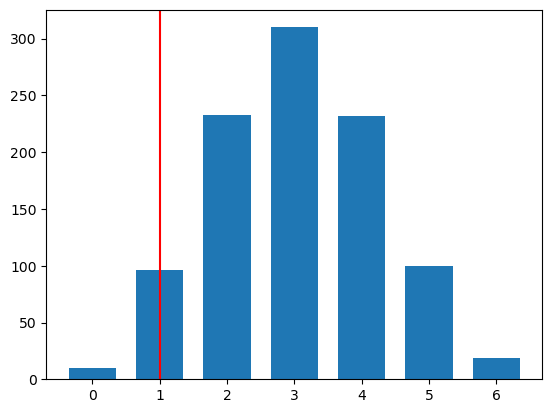

[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5]


In [77]:
bins = np.arange(all_results.min(), all_results.max() + 2) - 0.5

plt.hist(all_results, rwidth=.7, bins=bins)
plt.axvline(obs_num_heads, color='red')
plt.show()

print(bins)

### Example 1.3: A/B Testing

Simulated p-value: 0.137


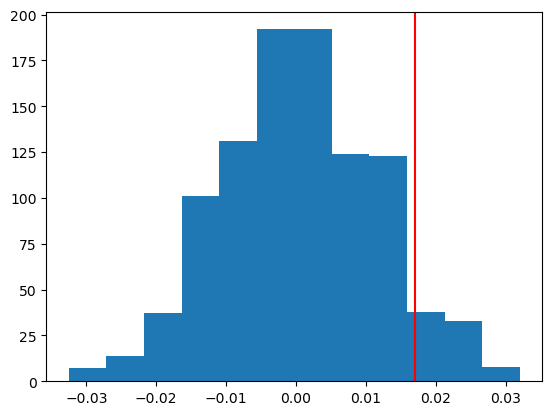

In [78]:
n_sim = 1000

my_viewsA = 98
my_viewsB = 162
all_views = my_viewsA + my_viewsB

n_impsA = 1000
n_impsB = 2000
all_imps = n_impsA + n_impsB

obs_T = abs(my_viewsA / n_impsA - my_viewsB / n_impsB)

null_Ts = np.zeros(n_sim) ## what we called "all_results" from before

for cur_sim in range(n_sim):
    pool = np.array([1] * all_views + [0] * (all_imps - all_views))
    impsA = np.random.choice(pool, n_impsA, replace=False)
    viewsA = np.sum(impsA)
    viewsB = all_views - viewsA

    diff = viewsA / n_impsA - viewsB / n_impsB
    null_Ts[cur_sim] = diff

sim_pval = np.sum(np.abs(null_Ts) >= np.abs(obs_T)) / n_sim

print(f"Simulated p-value: {sim_pval}")

plt.hist(null_Ts, bins=12)
plt.axvline(abs(obs_T), color='red')
plt.show()

### Example 1.4: independence test for contingency tables

In [79]:
K1 = 3
K2 = 2

con_table = [[350, 1200, 450], 
             [20, 120, 60]]

con_table = np.array(con_table)

column_sums = np.sum(con_table, axis=0)
row_sums = np.sum(con_table, axis=1)

In [80]:
## compute chi-squared test statistic
E = np.zeros((K2, K1))
for i in range(K2):
    for j in range(K1):
        E[i, j] = row_sums[i] * column_sums[j] / np.sum(con_table)

obs_T = np.sum((con_table - E)**2 / E)

n = int(np.sum(con_table))

In [81]:
## convert contingency table to data pairs
data_pairs = []
for i in range(K2):
    for j in range(K1):
        for _ in range(int(con_table[i, j])):
            data_pairs.append([i, j])
data_pairs = np.array(data_pairs)

[[ 332. 1205.  463.]
 [  38.  115.   47.]]
Simulated p-value using test statistic 1 = 0.011


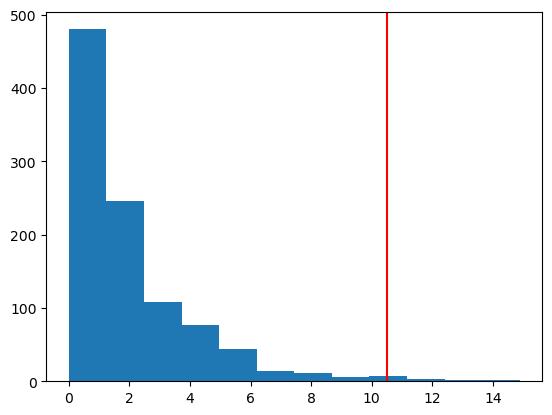

In [82]:
n_sim = 1000

all_null_Ts = np.zeros(n_sim)

for cur_sim in range(n_sim):
    ## permute the first column of data_pairs
    cur_sim_data = np.column_stack((np.random.choice(data_pairs[:, 0], n, replace=False), data_pairs[:, 1]))

    ## convert cur_sim_data to contingency table
    cur_sim_con_table = np.zeros((K2, K1))
    for i in range(n):
        cur_sim_con_table[cur_sim_data[i, 0], cur_sim_data[i, 1]] += 1
    
    null_T = np.sum((cur_sim_con_table - E)**2 / E)
    all_null_Ts[cur_sim] = null_T

print(cur_sim_con_table)

## compute p-value
p_value = np.mean(all_null_Ts >= obs_T)
print(f"Simulated p-value using test statistic 1 = {p_value}")

plt.hist(all_null_Ts, bins=12)
plt.axvline(obs_T, color='red')

In [83]:
## Use traditional pearson chi-squared test
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(con_table)
print(f"CLT-based p-value = {p:.4f}")

CLT-based p-value = 0.0053


### Example 1.5: independence test for continuous data

np.float64(0.7350457786848433)

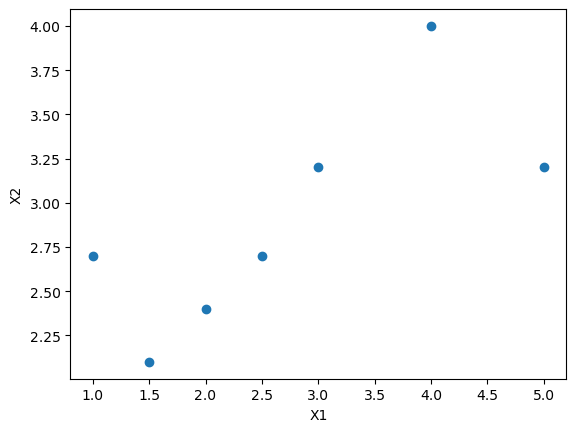

In [84]:
# Creating the X matrix
X = np.array([[2.5, 2.7], [4, 4.0], [5, 3.2], [1, 2.7], [3, 3.2], [2, 2.4], [1.5, 2.1]])

## plot variable X[, 0] vs X[, 1]
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel("X1")
plt.ylabel("X2")

np.corrcoef(X[:, 0], X[:, 1])[0, 1]


Simulated p-value: 0.046


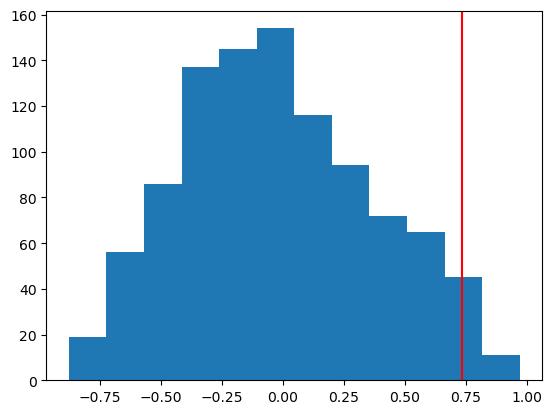

In [85]:
n = X.shape[0]

# Calculating the correlation of the original data
obs_T = np.corrcoef(X[:, 0], X[:, 1])[0, 1]

n_sim = 1000

null_Ts = np.zeros(n_sim)

for cur_sim in range(n_sim):
    # Shuffling only the first column of X
    Xprime = np.column_stack((np.random.choice(X[:, 0], n, replace=False), X[:, 1]))
    null_Ts[cur_sim] = np.corrcoef(Xprime[:, 0], Xprime[:, 1])[0, 1]

# Calculating the proportion of simulations where the absolute correlation is greater than my_corr
sim_pval = np.sum(np.abs(null_Ts) >= obs_T) / n_sim

print(f"Simulated p-value: {sim_pval}")

plt.hist(null_Ts, bins=12)
plt.axvline(obs_T, color='red')
plt.show()


## The Bootstrap

The bootstrap is a useful tool to approximate the uncertainty associated with an estimator or statistical learning method. The key idea of the bootstrap is to approximate the population distribution with the sample distribution.

### Example 1.7: confidence interval for the mean

We have a sample and we calculate a sample estimate. How do we quantify the uncertainty of this method?

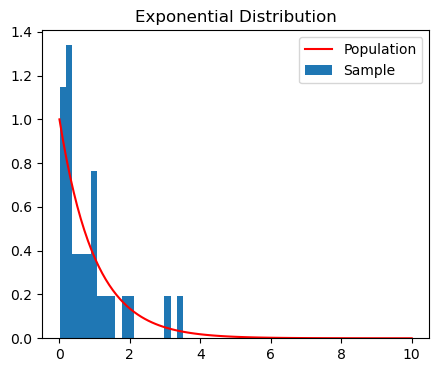

In [86]:
# draw sample
np.random.seed(42)
n = 30
x = np.random.exponential(scale=1, size=n)  

# calculate sample estimate
muhat = np.mean(x)
#muhat = np.median(x)

# get population distribution for plotting
x_vals = np.linspace(0, 10, 100)
pdf_vals = scipy.stats.expon.pdf(x_vals)

plt.figure(figsize=(5,4))
plt.plot(x_vals, pdf_vals, 'r', label='Population')
plt.hist(x, density=True, label='Sample', bins=20)
plt.title('Exponential Distribution')
plt.legend()

The bootstrap approximates the population distribution with the sample distribution. We draw with replacement from the sample distribution to obtain a sample. Doing this many times allows us to quantify the uncertainty associated with our estimator! 

![](fig/bootstrap_animation.gif)

In [87]:
n_boot = 1000

boot_muhats = np.zeros(n_boot)

for cur_boot in range(n_boot):
    xboot = np.random.choice(x, n, replace=True)
    boot_muhats[cur_boot] = np.mean(xboot)
    #boot_muhats[cur_boot] = np.median(xboot)

boot_std = np.std(boot_muhats)
conf_interval = [muhat - 2 * boot_std, muhat + 2 * boot_std]

print(f"Estimated: {muhat:.3f}")
print(f"Bootstrap standard deviation: {boot_std:.3f}")
print(f"Bootstrap confidence interval: ({conf_interval[0]:.3f}, {conf_interval[1]:.3f})")

Estimated: 0.806
Bootstrap standard deviation: 0.152
Bootstrap confidence interval: (0.502, 1.109)


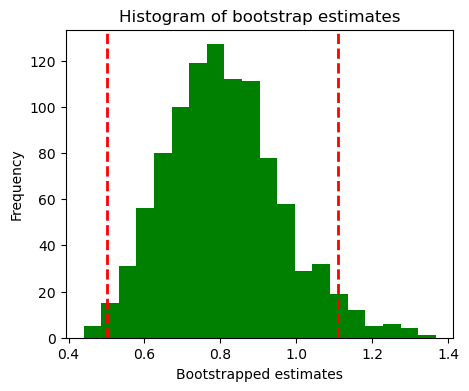

In [88]:
# Plotting the histogram of boot_muhats
plt.figure(figsize=(5,4))
plt.hist(boot_muhats, bins=20, color='green')
plt.xlabel('Bootstrapped estimates')
plt.ylabel('Frequency')
plt.title('Histogram of bootstrap estimates')
plt.axvline(conf_interval[0], color='red', linestyle='dashed', linewidth=2)
plt.axvline(conf_interval[1], color='red', linestyle='dashed', linewidth=2)
plt.show()


### Example 1.8: verifying the validity of bootstrap confidence intervals

In [89]:
n_sim = 1000
successes = np.zeros(n_sim)

for cur_sim in range(n_sim):
    n = 50
    x = np.random.poisson(lam=1, size=n)  # Poisson distribution with lambda=1
    mu = 1

    muhat = np.mean(x)

    n_boot = 500
    boot_muhats = np.zeros(n_boot)
    
    for cur_boot in range(n_boot):
        xboot = np.random.choice(x, n, replace=True)
        boot_muhats[cur_boot] = np.mean(xboot)

    boot_std = np.std(boot_muhats) 
    boot_ci = [muhat - 2 * boot_std, muhat + 2 * boot_std]
    
    if boot_ci[0] <= mu <= boot_ci[1]:
        successes[cur_sim] = 1

percent_success = np.sum(successes) / n_sim

print(f"Percent of experiments where the confidence interval contains the true mean: {percent_success}")


Percent of experiments where the confidence interval contains the true mean: 0.942


### Example 1.9 and 1.10: bootstrap tests for the mean

mean of X: -0.727  with n=11
bootstrap p-value: 0.078


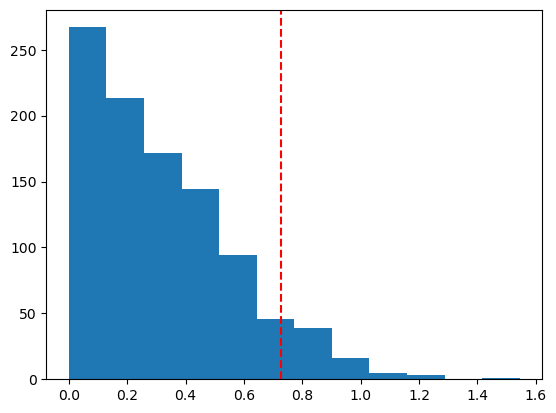

In [90]:
X = np.array([0.2, -1.9, 1.4, -2.7, -1.7, -1.4, 0.3, 1.2, -1.1, -0.2, -2.1])
n = len(X)

n_boot = 1000

print(f"mean of X: {np.mean(X):.3f}  with n={n}")

obs_T = abs(np.mean(X))

Xc = X - np.mean(X)

boot_Ts = np.zeros(n_boot)

for cur_boot in range(n_boot):
  Xboot = np.random.choice(Xc, n, replace=True)
  boot_Ts[cur_boot] = abs(np.mean(Xboot))

boot_pval = sum(boot_Ts >= obs_T)/n_boot

print(f"bootstrap p-value: {boot_pval}")

plt.hist(boot_Ts, bins=12)
plt.axvline(np.abs(obs_T), color='red', linestyle='dashed')

plt.show()

mean of X: 4.273,  mean of Y: 2.429
bootstrap p-value: 0.322


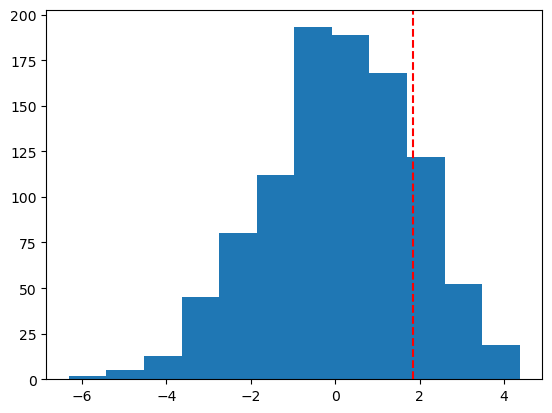

In [91]:
X = np.array([-1, 3, 5, 1, 10, 2, 9, 6, 6, 2, 4])
Y = np.array([11, -2, 1, 0, 0, 5, 2])

n = len(X)
m = len(Y)

n_boot = 1000

Xc = X - np.mean(X)
Yc = Y - np.mean(Y)

print(f"mean of X: {np.mean(X):.3f},  mean of Y: {np.mean(Y):.3f}")

obs_T = np.mean(X) - np.mean(Y)

boot_Ts = np.zeros(n_boot)

for cur_boot in range(n_boot):
  Xboot = np.random.choice(Xc, n, replace=True)
  Yboot = np.random.choice(Yc, m, replace=True)
  boot_Ts[cur_boot] = np.mean(Xboot) - np.mean(Yboot)

boot_pval = sum(np.abs(boot_Ts) >= np.abs(obs_T))/n_boot

print(f"bootstrap p-value: {boot_pval}")

plt.hist(boot_Ts, bins=12)
plt.axvline(np.abs(obs_T), linestyle='dashed', color='red')

plt.show()